## LSTM 주식 시작가 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 데이터 로딩
file_path = "D:/AI_data/AAME.csv"
df = pd.read_csv(file_path, index_col=0)

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.00,4.05,3.85,3.85,3.213167,15000
1980-03-18,0.00,4.00,3.80,3.80,3.171437,10200
1980-03-19,0.00,4.05,3.85,3.85,3.213167,33500
1980-03-20,0.00,4.00,3.80,3.80,3.171437,8700
1980-03-21,0.00,3.95,3.75,3.75,3.129709,12700
...,...,...,...,...,...,...
2020-03-26,2.29,2.29,2.08,2.28,2.280000,1600
2020-03-27,2.25,2.25,2.21,2.25,2.250000,500
2020-03-30,2.25,2.25,2.13,2.13,2.130000,400


In [3]:
df = df[['Open']]
df

,Open
Date,
1980-03-17,0.00
1980-03-18,0.00
1980-03-19,0.00
1980-03-20,0.00
1980-03-21,0.00
...,...
2020-03-26,2.29
2020-03-27,2.25
2020-03-30,2.25


In [4]:
openValues = df[['Open']]

In [5]:
# 특징값 정규화
# 신경망의 입력은 0-1 사이의 실수여야 함
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(openValues)

In [6]:
# 훈련 데이터와 테스트 데이터의 분리
TEST_SIZE = 2000
train_data = scaled[:-TEST_SIZE]
test_data = scaled[-TEST_SIZE:] # 후반부의 2000개를 테스트 데이터로 사용

In [7]:
# 순차 훈련 데이터 생성
# lSTM은 훈련 데이터가 3D 배열일 것으로 예상 -> 데이터를 60개씩 분리하여 묶어야 함
def make_sample(data, window):
    train = []
    target = []
    
    for i in range(len(data)-window):
        train.append(data[i:i+window])
        target.append(data[i+window])

    return np.array(train), np.array(target)

X_train, y_train = make_sample(train_data, 100)

In [8]:
X_train.shape, y_train.shape

((7998, 100, 1), (7998, 1))

In [9]:
# lSTM 구축하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, # 셀 개수 
               input_shape=(X_train.shape[1], 1), # 훈련 데이터의 두 번째 차원을 입력으로 줌 = 100
               activation='tanh',
               return_sequences=False) # 마지막 출력만 반환 
         )
model.add(Dense(1)) # 최종 출력을 위해 Dense 레이어 가가

C:\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# 모델 학습
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 10, batch_size = 16)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 0.0028
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0031
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - loss: 0.0027
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0034
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0032
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - loss: 0.0033
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0022
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0027
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.0031
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - loss: 0.0026


In [15]:
# 테스트셋을 이용하여 미래 주가 예측
X_test, y_test = make_sample(test_data, 100)
pred = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


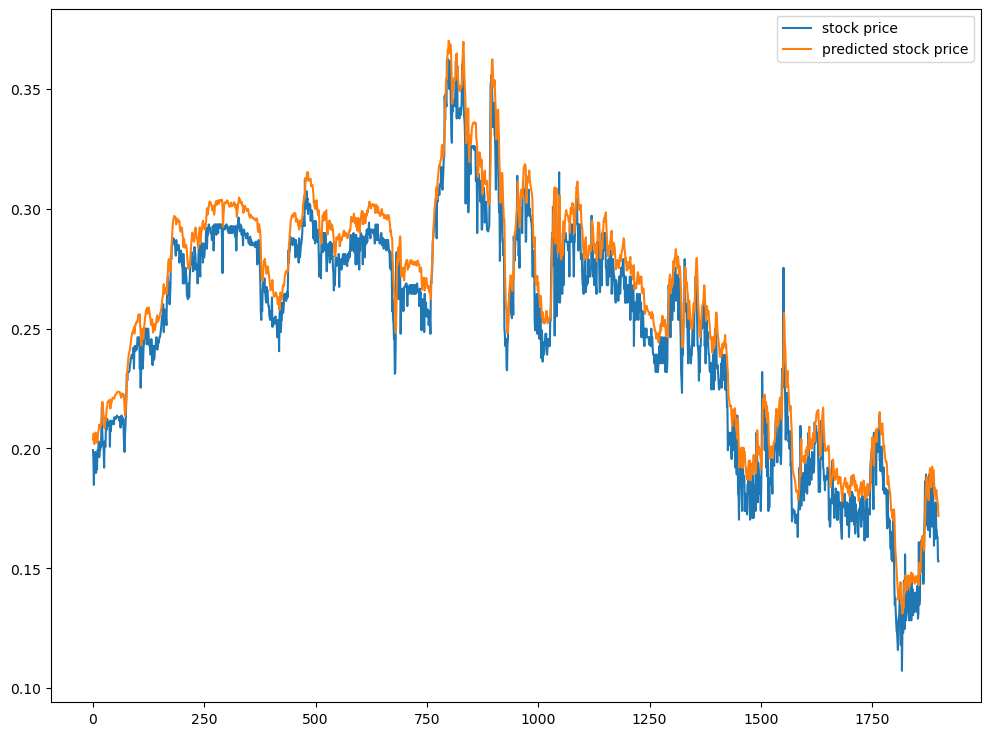

In [16]:
# 그래프 그리기
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.plot(y_test, label='stock price')
plt.plot(pred, label='predicted stock price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MSE:", mean_squared_error(y_test, pred))
print("MAE:", mean_absolute_error(y_test, pred))
print("R² score:", r2_score(y_test, pred))

MSE: 0.00017636745793590052
MAE: 0.011497698587076822
R² score: 0.9267149313230554
